# Text Extraction and Sentiment Analysis

In this Notebook we try to get the text of English lute songs and use a pre-trained text classification model to do a brief sentiment analysis.

In [1]:
import numpy as np
import pandas as pd

# navigating directories
import os

# language detection
from langdetect import detect

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots


# huggingface model
from transformers import AutoTokenizer, pipeline

# statistics
from statsmodels.stats.weightstats import ttest_ind
import pingouin as pg

import math

import pretty_midi
from tqdm import tqdm
import json

In [2]:
sns.set_style('darkgrid')

# Lute Song Text Extraction

In [4]:
wd = os.getcwd()

lute_df_path = os.path.join(wd, 'data', 'data_sets', 'lute_data.csv')
lute_df = pd.read_csv(lute_df_path)
lute_df['Date'] = lute_df['Date'].str.replace('[^0-9]','', regex=True).astype(int)

composer_df_path = os.path.join(wd, 'data', 'data_sets', 'scraped_composer_data_cleaned.csv')
composer_df = pd.read_csv(composer_df_path, encoding='latin-1')

# rename composers in the main dataset
names_df_path = os.path.join(wd, 'data', 'data_sets', 'cleaned_composers.csv')
names_df = pd.read_csv(names_df_path, encoding='latin-1', index_col='Composer')
lute_df['Composer'] = lute_df['Composer'].apply(lambda x: names_df.loc[x].cleaned_name)

# merge piece data with composer data 
lute_df_comp = lute_df.merge(composer_df, how='left', left_on='Composer', right_on='composer').copy()
lute_df_comp.shape

(20426, 38)

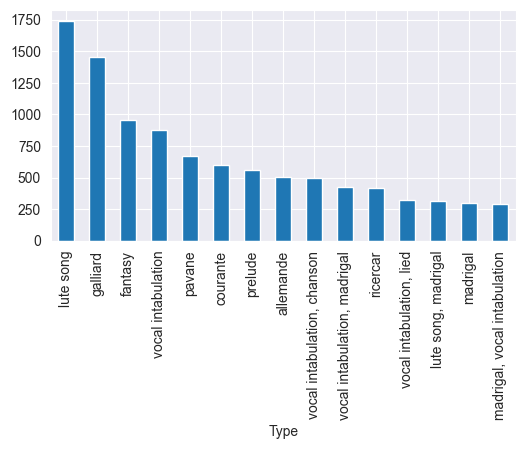

In [4]:
fig = plt.figure(figsize=(6,3))
lute_df_comp.Type.value_counts()[:15].plot(kind='bar')
plt.show()

In [5]:
lute_songs = lute_df_comp.query(
    # select all Types that could be lute songs
    '(Type == "lute song" '
    'or Type == "air de cour" '
    'or Type == "Air de cour" '
    'or Type == "lute song, religious" '
    'or Type == "psalm, lute song" '
    'or Type == "lute song, madrigal" '
    'or Type == "madrigal, lute song") '
    # filter out arrangements (e.g. the Barabara Strozzi pieces that contain no lute part in the original)
    'and Arranger.isnull()'
)

lute_songs.shape

(2186, 38)

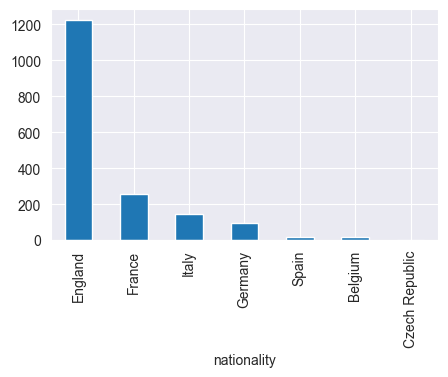

In [6]:
fig = plt.figure(figsize=(5,3))
lute_songs.nationality.value_counts().plot(kind='bar')
plt.show()

In [8]:
lute_songs.Document.value_counts()[:15]

Document
Airs de Differents Auteurs                 402
Pseaumes de David                          173
Second book of ayres                       170
First book of ayres                        152
Third book of ayres                        146
Ayres                                      145
mus.c.311:Bottegari Lute Book               94
A Musicall Banquet                          90
A Booke of Ayres                            85
First Book of Songs                         83
Fourth book of ayres:A Pilgrim's Solace     71
Ein Newgeordent K?nstlich Lautenbuch        54
First book of airs                          53
Fourth book of ayres                        48
Ayres to Sing and Play                      44
Name: count, dtype: int64

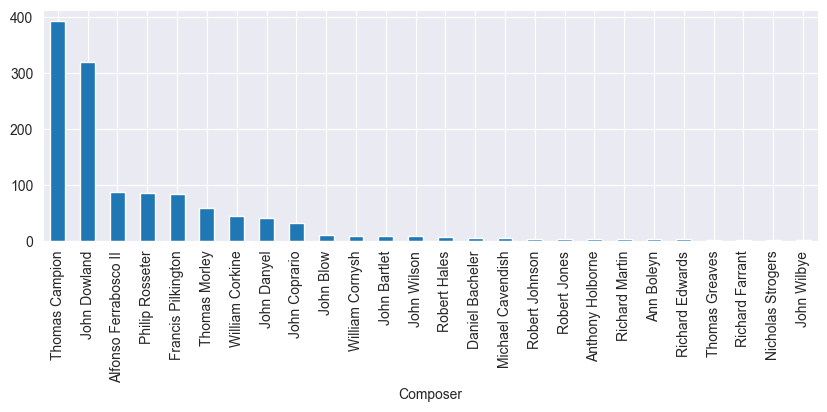

In [14]:
english_lute_songs = lute_songs.query('nationality == "England"')
len(english_lute_songs)

fig = plt.figure(figsize=(10,3))
english_lute_songs.Composer.value_counts().plot(kind='bar')
plt.show()

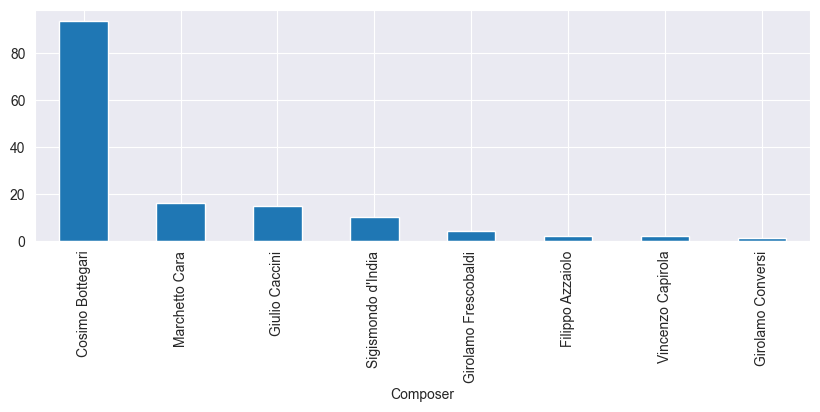

In [15]:
italian_lute_songs = lute_songs.query('nationality == "Italy"')
len(english_lute_songs)

fig = plt.figure(figsize=(10,3))
italian_lute_songs.Composer.value_counts().plot(kind='bar')
plt.show()

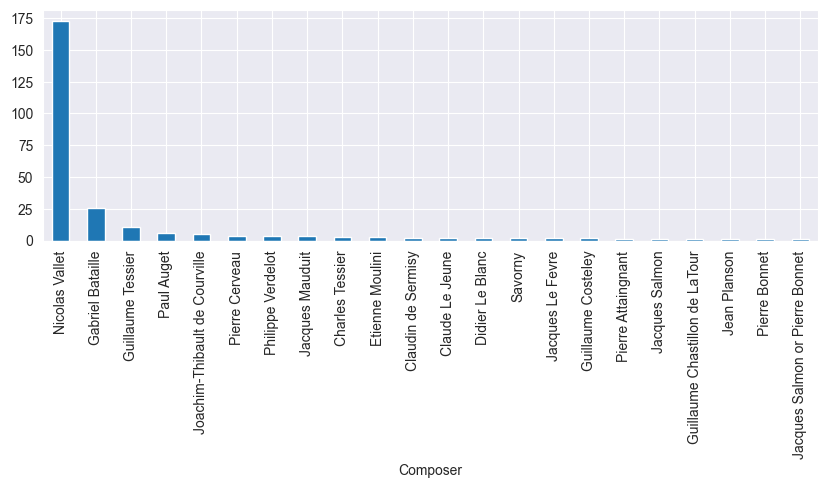

In [16]:
french_lute_songs = lute_songs.query('nationality == "France"')
len(english_lute_songs)

fig = plt.figure(figsize=(10,3))
french_lute_songs.Composer.value_counts().plot(kind='bar')
plt.show()

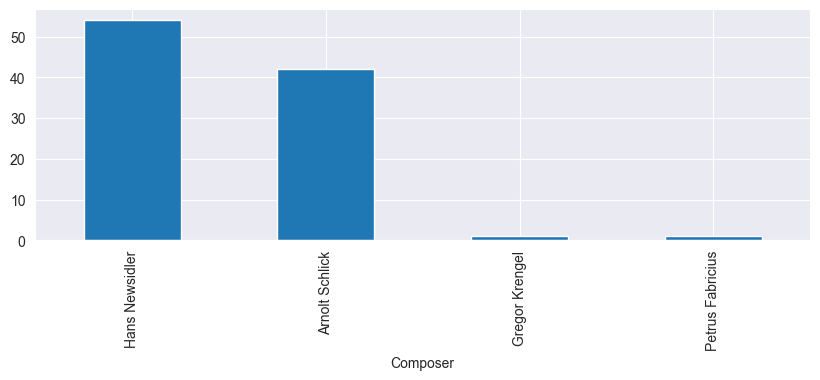

In [17]:
german_lute_songs = lute_songs.query('nationality == "Germany"')
len(german_lute_songs)

fig = plt.figure(figsize=(10,3))
german_lute_songs.Composer.value_counts().plot(kind='bar')
plt.show()

In [18]:
midi_directory = os.path.join(wd, 'data', 'midi_files')
files = os.listdir(midi_directory)

for index, row in lute_songs.iterrows():
    
    try:
        file_name = f'file_{index}.mid'
        file_path = os.path.join(midi_directory, file_name)
    
        midi_object = pretty_midi.PrettyMIDI(file_path)
        lyrics = [lyrics_event.text for lyrics_event in midi_object.lyrics]
        lyrics = ''.join(lyrics)
        language = detect(lyrics)
    
        lute_songs.loc[index, 'lyrics'] = lyrics
        lute_songs.loc[index, 'language'] = language

    except:
        print(f'file {file_name} contains no lyrics or no proper language')

C:\Users\jakob\AppData\Local\Temp\ipykernel_14412\458822377.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lute_songs.loc[index, 'lyrics'] = lyrics
C:\Users\jakob\AppData\Local\Temp\ipykernel_14412\458822377.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lute_songs.loc[index, 'language'] = language


file file_69.mid contains no lyrics or no proper language
file file_91.mid contains no lyrics or no proper language
file file_120.mid contains no lyrics or no proper language
file file_122.mid contains no lyrics or no proper language
file file_124.mid contains no lyrics or no proper language
file file_126.mid contains no lyrics or no proper language
file file_133.mid contains no lyrics or no proper language
file file_141.mid contains no lyrics or no proper language
file file_143.mid contains no lyrics or no proper language
file file_146.mid contains no lyrics or no proper language
file file_148.mid contains no lyrics or no proper language
file file_154.mid contains no lyrics or no proper language
file file_156.mid contains no lyrics or no proper language
file file_165.mid contains no lyrics or no proper language
file file_166.mid contains no lyrics or no proper language
file file_182.mid contains no lyrics or no proper language
file file_184.mid contains no lyrics or no proper language

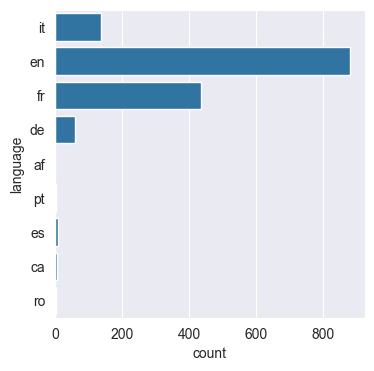

In [19]:
fig = plt.figure(figsize=(4,4))
sns.countplot(lute_songs.language)
plt.show()

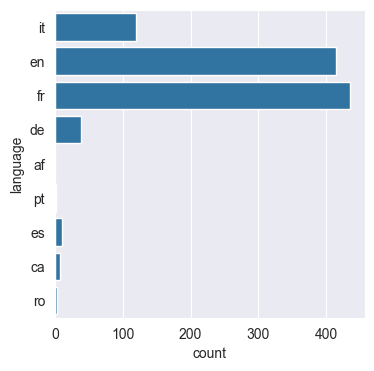

In [20]:
fig = plt.figure(figsize=(4,4))
lute_songs_unique = lute_songs.drop_duplicates(subset=['lyrics']).copy()
lute_songs_unique = lute_songs_unique.dropna(subset=['lyrics'])
sns.countplot(lute_songs_unique.language)
plt.show()

In [26]:
lute_songs_unique.query("language == 'fr'").Document.value_counts()

Document
Airs de Differents Auteurs                  390
Pseaumes de David                            21
Chant ? 4 parties                             3
mus.c.311:Bottegari Lute Book                 2
Orphenica Lyra                                2
Tres Breve et Famili?re Introduction          2
Airs de cour avec la tabulature de leut       1
Silva de Sirenas                              1
Ein Newgeordent K?nstlich Lautenbuch          1
ms 1G i.27:Brogyntyn lute book                1
Airs de different auteurs                     1
MS 1379 [92] no.1469                          1
Airs de Cours avec tabulature de leut         1
Troisi?me Livre d'Airs                        1
Vingt et sept chansons musicales              1
Thesaurus Harmonicus                          1
Musica Transalpina                            1
MS Q16                                        1
Pratum Musicum                                1
Airs de Cours avec le tabulature de leut      1
Premiere livre d'airs de cour  

In [28]:
lute_songs_unique.query("Document == 'Airs de Differents Auteurs'").head().Facsimile.values

array(['https://lutemusic.org/facsimiles/BatailleG/Airs_de_Differents_Auteurs/v.1_1608/02v.png',
       'https://lutemusic.org/facsimiles/BatailleG/Airs_de_Differents_Auteurs/v.1_1608/03v.png',
       'https://lutemusic.org/facsimiles/BatailleG/Airs_de_Differents_Auteurs/v.1_1608/04v.png',
       'https://lutemusic.org/facsimiles/BatailleG/Airs_de_Differents_Auteurs/v.1_1608/05v.png',
       'https://lutemusic.org/facsimiles/BatailleG/Airs_de_Differents_Auteurs/v.1_1608/06v.png'],
      dtype=object)

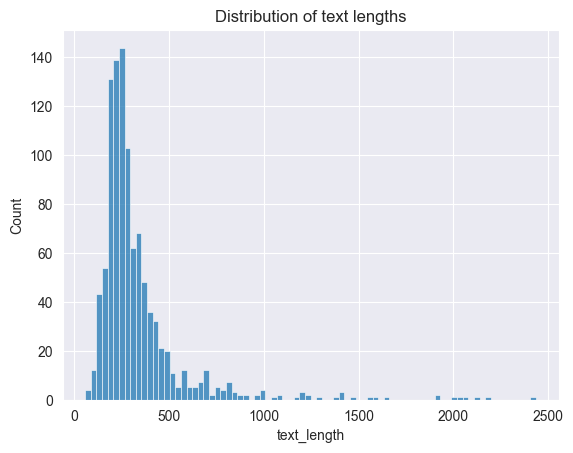

In [16]:
# create a new column with text lengths
lute_songs_unique['text_length'] = lute_songs_unique.lyrics.apply(lambda x: len(x))

sns.histplot(data=lute_songs_unique, x='text_length', bins=80)
plt.title('Distribution of text lengths')
plt.show()

In [17]:
def plot_wordcloud(df):
    song_texts = df.lyrics.values
    song_texts = " ".join(song_texts)
    text=(song_texts)
    
    wordcloud = WordCloud(width=800, height=500, margin=0).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

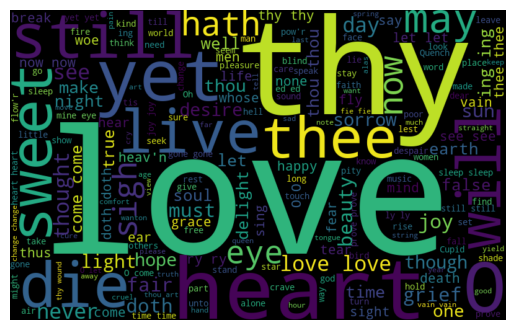

In [18]:
plot_wordcloud(lute_songs_unique.query("language == 'en'"))

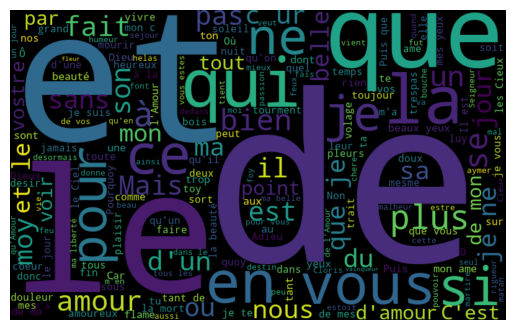

In [19]:
plot_wordcloud(lute_songs_unique.query("language == 'fr'"))

In [20]:
text = ' '.join(lute_songs_unique.query("language == 'en'").lyrics)

In [21]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
stop_words = set(stopwords.words('english'))
text_list = word_tokenize(text.lower())
filtered_text_list = [w for w in text_list if not w in stop_words]

In [27]:
word_counts = {}

for word in filtered_text_list:
    word = word.replace('.', '')
    word = word.replace(',', '')
    word_counts[word] = word_counts.get(word, 0) + 1

sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

In [28]:
def log_transform(freq_dict):
    return {k: math.log(v + 1) for k, v in freq_dict.items()}

normalized_dict = log_transform(sorted_word_counts)

with open('text_counts.txt', 'w', encoding='utf-8') as f:
    for key, value in normalized_dict.items():
        f.write('{text: "' + key + '", weight: ' + str(value) + '},\n')

In [29]:
sorted_word_counts['leave']

23

# Sentiment Analysis

In the second part of this Notebook we do a little sentiment analysis with the text we have so laboriously collected. First, we import a pre-trained model fine-tuned for emotion classification from Hugging Face. Then we compute and plot sentiment scores for our lute songs. We briefly look at the most cheerful and sad texts. Next we try to figure out which composer is the most depressed. Finally, we compare the sentiments of songs in major and minor keys. Our hypothesis: minor songs are sadder than major songs.

I tried to pick a model that used different kinds of labled training data for fine-tuning, not just the usual Tweets. But it is still a bit doubtful if it will be reliable for classifying emotions in 16th and 17th century poetry. But since this is just a fun exercise, let's simply try it!

In [33]:
def get_emotion_scores(df, classifier, tokenizer):

    emotions = {}
    for i, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing songs"):
        song_text = row.lyrics
        
        # tokenize and truncate the text to the model's max length
        tokens = tokenizer.tokenize(song_text)
        truncated_tokens = tokens[:tokenizer.model_max_length - 2]  # account for special tokens
        truncated_text = tokenizer.convert_tokens_to_string(truncated_tokens)
        
        results = classifier(truncated_text)[0]
        emotions[i] = {}
        for x in results:
            emotions[i][x['label']] = x['score']

    # turn dict into dataframe        
    emotion_scores_df = pd.DataFrame(emotions).transpose()
    
    return emotion_scores_df

In [31]:
# the model we will use
model_name = "j-hartmann/emotion-english-distilroberta-base"
classifier = pipeline("text-classification", model=model_name, top_k=None)
tokenizer = AutoTokenizer.from_pretrained(model_name)

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [115]:
emotions_df = get_emotion_scores(lute_songs_unique.query("language == 'en'"), classifier, tokenizer)
emotions_df.head()

Processing songs: 100%|██████████████████████████████████████████████████████████████| 416/416 [02:01<00:00,  3.43it/s]


,sadness,fear,anger,neutral,disgust,joy,surprise
90,0.942362,0.033550,0.008463,0.006609,0.004570,0.003149,0.001297
118,0.980875,0.008577,0.002273,0.002090,0.000558,0.003608,0.002019
121,0.037216,0.020650,0.142159,0.144621,0.347286,0.303386,0.004682
123,0.259061,0.277765,0.055360,0.083630,0.035139,0.150655,0.138390
125,0.135670,0.034037,0.037262,0.148158,0.005858,0.432623,0.206392


In [124]:
emotions_df_path = os.path.join(wd, 'data', 'data_sets', 'emotions_english_lute_songs.csv')
emotions_df_songs = pd.merge(lute_songs_unique.query("language == 'en'"), emotions_df, how='inner', left_index=True, right_index=True)
emotions_df_songs.to_csv(emotions_df_path)

## Summary of Emotion Scores

OK, now that we've got some data, let's summarize and plot it!

In [5]:
# load data (it's already merged with the lute song dataframe) and show summary statistics
lute_songs_emotions_path = os.path.join(wd, "data", "data_sets", "emotions_english_lute_songs.csv")
lute_songs_emotions_df = pd.read_csv(lute_songs_emotions_path)

# summary statistics
lute_songs_emotions_df[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']].agg(["mean", "median"])

,anger,disgust,fear,joy,neutral,sadness,surprise
mean,0.162942,0.058555,0.165450,0.123910,0.123791,0.342660,0.022692
median,0.054054,0.019478,0.045404,0.009266,0.041735,0.124831,0.003061


Looks like sadness is the dominant emotion. But there are slight traces of anger, fear, and joy in the data.

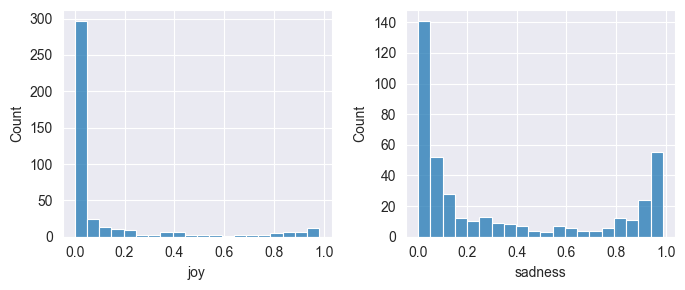

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(7,3))
sns.histplot(data=lute_songs_emotions_df, x="joy", bins=20, ax=axs[0])
sns.histplot(data=lute_songs_emotions_df, x="sadness", bins=20, ax=axs[1])

plt.tight_layout()
plt.show()

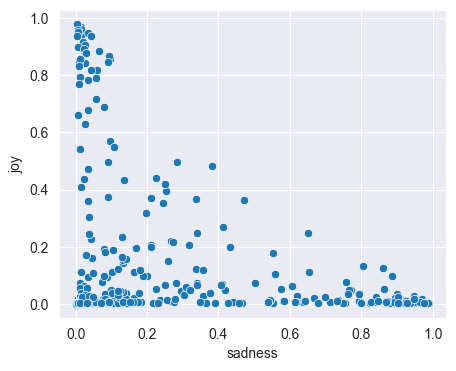

In [34]:
fig = plt.figure(figsize=(5,4))
sns.scatterplot(data=lute_songs_emotions_df, x='sadness', y='joy')
plt.show()

The shape of the distributions suggests that the model is quite confident in its predictions.

## Pieces Ranking Highest on Joy and Sadness

Next, we take a quick glance at the most joyfull and sad texts.

In [7]:
lute_songs_emotions_df.sort_values("joy", ascending=False)[["Title", "Composer", "joy", "lyrics"]].head()

,Title,Composer,joy,lyrics
173,Move now with measured sound,Thomas Campion,0.980568,"Move now with measur'd sound, you charming gro..."
10,14. Down in a valley,Michael Cavendish,0.970284,"Down in a valley, down in a valley, Shady vale..."
154,There is a garden in her face,Thomas Campion,0.963637,"There is a garden in her face, Where roses and..."
175,Triumph now with joy and mirth,Thomas Campion,0.959415,Triumph now with joy and mirth the God of peac...
94,Jack and Joan,Thomas Campion,0.957651,"Jack and Joan they think no ill, But loving li..."


In [8]:
lute_songs_emotions_df.loc[173].lyrics

"Move now with measur'd sound, you charming grove of gold; trace forth the sacred ground that shall your forms unfold. Diana and the starry night for your Apollo's sake Endue your silvan shapes with pow'r, this strange delight to make. Much joy must needs the place betide where trees for gladness move. A fairer sight was ne'er beheld, or more expressing love. "

In [10]:
lute_songs_emotions_df.sort_values("sadness", ascending=False)[["Title", "Composer", "sadness", "lyrics"]].head(10)

,Title,Composer,sadness,lyrics
142,Could my heart,Thomas Campion,0.988314,Could my heart more tongues employ Than it har...
321,From silent night,John Dowland,0.987142,"From silent night, true register of moans, - ..."
122,So tired are all my thoughts,Thomas Campion,0.985643,So tired are all my thoughts That sense and sp...
67,Discontent,John Wilson,0.985346,"I prithee turn that face a way, whose splendor..."
256,I saw my lady weep,John Dowland,0.985151,I saw my lady weep And sorrow proud to be ad...
203,4. If streams of tears,William Corkine,0.985140,If streams of tears could lessen extreme grief...
219,Like as the lute delights,John Danyel,0.984507,"Like as the lute delights, delights or else, o..."
63,"What, then, is love but mourning?",Philip Rosseter,0.982880,"What, then, is love but mourning? What desire ..."
235,If my complaints,John Dowland,0.982817,"If my complaints could passions move, Or make ..."
238,"Now, O now I needs must part",John Dowland,0.982796,"Now, O now I needs must part, Parting though I..."


In [13]:
lute_songs_emotions_df.loc[238][['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']]

anger       0.001345
disgust     0.000808
fear        0.002498
joy         0.006154
neutral     0.002944
sadness     0.982796
surprise    0.003455
Name: 238, dtype: object

## Sadness by Mode and Composer

To conclude the sentiment part, we test our hypothesis that songs in minor keys have sadder texts than songs in major. First, we plot the distributions and give summary stats for each subgroup.

In [18]:
maj_keys = lambda x: 'Major' if x in ['FM', 'CM', 'GM', 'BbM', 'DM', 'EbM', 'AM'] else 'Minor'
lute_songs_emotions_df['mode'] = lute_songs_emotions_df['Key'].apply(maj_keys)

In [45]:
lute_songs_emotions_df.groupby('mode').size().sort_values(ascending=False)

mode
Minor    244
Major    172
dtype: int64

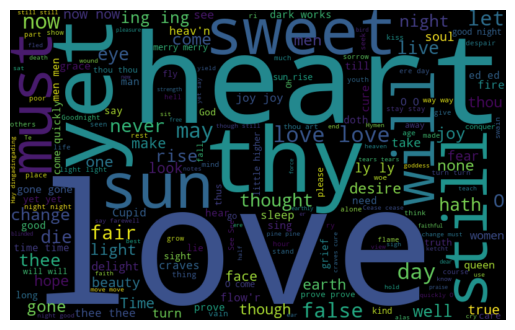

In [46]:
plot_wordcloud(lute_songs_emotions_df.query("mode == 'Major'"))

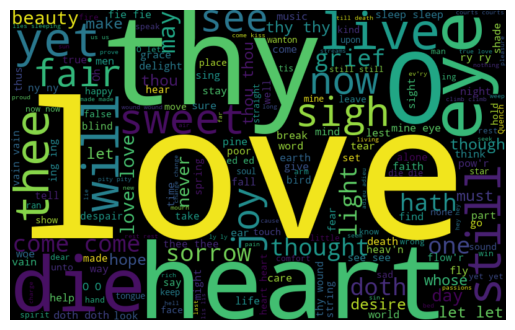

In [47]:
plot_wordcloud(lute_songs_emotions_df.query("mode == 'Minor'"))

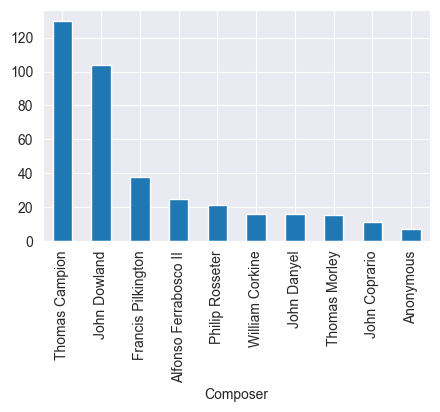

In [48]:
fig = plt.figure(figsize=(5,3))
lute_songs_emotions_df.groupby('Composer').size().sort_values(ascending=False).head(10).plot.bar()
plt.show()

In [16]:
imp_comp = lute_songs_emotions_df.Composer.value_counts()[:6].index
imp_comp_df = lute_songs_emotions_df.query("Composer in @imp_comp")[['Composer', 'sadness']]

sadness = imp_comp_df.groupby('Composer').agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in sadness.index:
    m, c, s = sadness.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

sadness['ci95_lo'] = ci95_lo    
sadness['ci95_hi'] = ci95_hi

sadness = sadness.reset_index()
sadness.columns = ['Composer', 'mean', 'count', 'std', 'ci95_lo', 'ci95_hi']
sadness['ci'] = (sadness['ci95_hi'] - sadness['ci95_lo']) / 2
sadness = sadness.sort_values('mean')

sadness

,Composer,mean,count,std,ci95_lo,ci95_hi,ci
1,Francis Pilkington,0.224846,38,0.272190,0.138302,0.311390,0.086544
0,Alfonso Ferrabosco II,0.235302,25,0.359813,0.094256,0.376349,0.141047
2,John Danyel,0.266361,16,0.313586,0.112703,0.420018,0.153657
5,Thomas Campion,0.276381,130,0.355741,0.215228,0.337534,0.061153
4,Philip Rosseter,0.392376,21,0.412641,0.215887,0.568865,0.176489
3,John Dowland,0.463780,104,0.397597,0.387364,0.540195,0.076416


In [50]:
def export_and_plot(fig, file_name, width=585):
    path = os.path.join('plots', f'{file_name}.json')
    json_data = fig.to_json()
    with open(path, 'w') as f:
            f.write(json_data)

    fig.update_layout(width=width)
    fig.show()

In [57]:
trace1 = px.histogram(
    lute_songs_emotions_df,
    x='sadness',
    color='mode',
    labels={'mode':'Mode', 'sadness':'Sadness Score', 'percent':'Percent'},
    opacity=0.7,
    histnorm='percent',
    nbins=10,
    color_discrete_sequence=['#b2e061', '#5F9AA2']
).data

trace2 = go.Bar(
    y=sadness['Composer'],
    x=sadness['mean'],
    orientation='h',
    error_x=dict(
        type='data',
        array=sadness['ci'],
        color='#303030',
        thickness=1,
        width=7,
    ),
    width=0.7,
    showlegend=False,
    marker=dict(
        color="#b2e061",
        opacity=0.7
    ),
    #hoverinfo='skip',
    name=''
)


fig = make_subplots(
    rows=2, cols=1,
    specs=[[{}], [{}]],
    shared_xaxes=True,
    shared_yaxes=False,
    vertical_spacing=0.001
)

for trace in trace1:
    fig.append_trace(trace, 1, 1)
    
fig.append_trace(trace2, 2, 1)

#fig.update_traces(marker_line_color='#303030', marker_line_width=0, row=1, col=1)
fig.update_traces(
    marker_line_color='#303030',
    marker_line_width=0.5, row=2, col=1
)

fig.update_layout(
    height=600,
    margin=dict(l=0,r=0,b=0,t=50),
    title=dict(text='Sadness in English Lute Songs', font=dict(size=25)),
    showlegend=True,
    template='simple_white',
    legend=dict(title=None, x=1, y=1, xanchor='right', yanchor='top'),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.update_xaxes(showline=True, linewidth=0, linecolor='black', ticks='', row=1, col=1)
fig.update_xaxes(title='Sadness Score', linewidth=0, linecolor='black', ticks='outside', row=2, col=1)
fig.update_yaxes(title='Percent', row=1, col=1)


export_and_plot(fig, 'sentiment_plot', width=480)

## Hypothesis Testing

In [23]:
lute_songs_emotions_df.groupby('mode')['sadness'].agg(['mean', 'median', 'var', 'count'])

,mean,median,var,count
mode,,,,
Major,0.257191,0.082304,0.116618,172
Minor,0.402908,0.228225,0.148270,244


Our data obviously isn't normally distributed. The homogeneity of variance assumption is not satisfied.

In [20]:
X = lute_songs_emotions_df.query("mode == 'Major'").sadness.to_numpy()
Y = lute_songs_emotions_df.query("mode == 'Minor'").sadness.to_numpy()

# compare variances
pg.homoscedasticity([X, Y]).round(3)

,W,pval,equal_var
levene,15.796,0.0,False


We use a non-parametric test.

In [22]:
pg.mwu(X, Y, alternative="less")

,U-val,alternative,p-val,RBC,CLES
MWU,15876.0,less,0.000012,0.243424,0.621712


In [30]:
from tqdm import tqdm
tqdm.pandas()

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [35]:
def light_preprocessor(s):
    s = s.strip().lower()
    re.sub(r'\([^d]*\d{4}\)', "", s)
    s = s.replace('\n'," ")
    s = s.replace('etc.',"")
    s = s.replace('e.g.',"")
    s = s.replace('i.e.',"")
    s = s.replace('-', "")
    s = s.replace('.', "")
    s = s.replace(',', "")
    s = s.replace(':', "")
    s = s.replace('(', "")
    s = s.replace(')', "")
    s = s.replace('!', "")
    s = s.replace('?', "")
    s = s.replace(';', "")
    s = s.replace("'", "")
    s=re.sub(r'http\S+', '', s)
    s = re.sub(r'\d+', '', s)
    return s


selected_words = ['would', 'shall', 'thy', 'thou', 'thee', 'dost', 'let', 'may', 'one', 'hath', 'yet', 'must', 'doth', 'thu', 'though', 'lest', 'till'] 
stopwords_english = stopwords.words('english') + selected_words
stemmer = PorterStemmer()


def split_stem_tokenize(text):
    splitted = text.split()
    clean_splitted = []
    for word in splitted:
        if not word in stopwords_english: 
            stem_word = stemmer.stem(word)
            clean_splitted.append(stem_word)
    return ' '.join(clean_splitted)

In [36]:
text = ' '.join(lute_songs_emotions_df['lyrics'].to_list())

with open('long_text.txt', 'w') as f:
    f.write(text)

In [37]:
X = lute_songs_emotions_df['lyrics']
X = X.apply(light_preprocessor)
X = X.apply(split_stem_tokenize)
X = X.to_numpy()

vectorizer = TfidfVectorizer(min_df=1, stop_words=stopwords_english)
X = vectorizer.fit_transform(X).toarray()

X.shape

(416, 2876)

In [38]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
nmf_model = NMF(n_components=3)
nmf_model.fit(X)

NMF(n_components=3)

In [40]:
topics_df = pd.DataFrame(nmf_model.components_, columns=vectorizer.get_feature_names_out())

for index, row in topics_df.iterrows():
    imp_words = row.nlargest(10)
    print(f'Topic {index}:')
    print(imp_words)
    print('\n')

Topic 0:
love      0.819333
heart     0.462110
still     0.407485
joy       0.294647
beauti    0.259371
fair      0.255922
eye       0.246957
ill       0.223449
sweet     0.213194
sigh      0.211658
Name: 0, dtype: float64


Topic 1:
come       0.982167
die        0.654004
live       0.229003
wound      0.219055
death      0.179669
kiss       0.177012
quickli    0.172511
sweet      0.151132
see        0.118251
sorrow     0.112614
Name: 1, dtype: float64


Topic 2:
sun      0.660506
night    0.486750
dark     0.460980
chang    0.337315
light    0.334061
day      0.332089
work     0.325880
sleep    0.235363
rise     0.208878
mourn    0.177954
Name: 2, dtype: float64


